In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np 
import re
from pathlib import Path

import mplhep as hep
hep.style.use(hep.style.ATLAS)

from utils import read_perf_analyzer_output, plot_backend_compare
from utils import plot_backend, check_inputpath, check_outputpath

# 1 instance on 1 GPU

In [2]:
custom_backend_results_path = "/pscratch/sd/h/hrzhao/Projects/exatrkx-service/evaluate/slurm/good-1gpu-slurm-16730083/1insts_1gpus/perf_analyzer_16730083_1insts_1gpus_sync.csv"
ensemble_backend_results_path = "/pscratch/sd/h/hrzhao/Projects/exatrkx-service/evaluate_ensemble/slurm/good-1gpu-slurm-16748159/ensemble_1insts_1gpus/perf_analyzer_16748159_1insts_1gpus_sync.csv"
var_name = "Inferences/Second"

direct_inference_results = {
    "Concurrency": [1, 2, 4, 8, 10, 16],
    var_name: [44, 57, 63, 65, 64, 64]
}


In [3]:
pd_custom = read_perf_analyzer_output(custom_backend_results_path)
custom_backend_results = {
    "Concurrency": pd_custom["Concurrency"],
    var_name: pd_custom[var_name]
}

pd_ensemble = read_perf_analyzer_output(ensemble_backend_results_path)
ensemble_backend_results = {
    "Concurrency": pd_ensemble["Concurrency"],
    var_name: pd_ensemble[var_name]
}

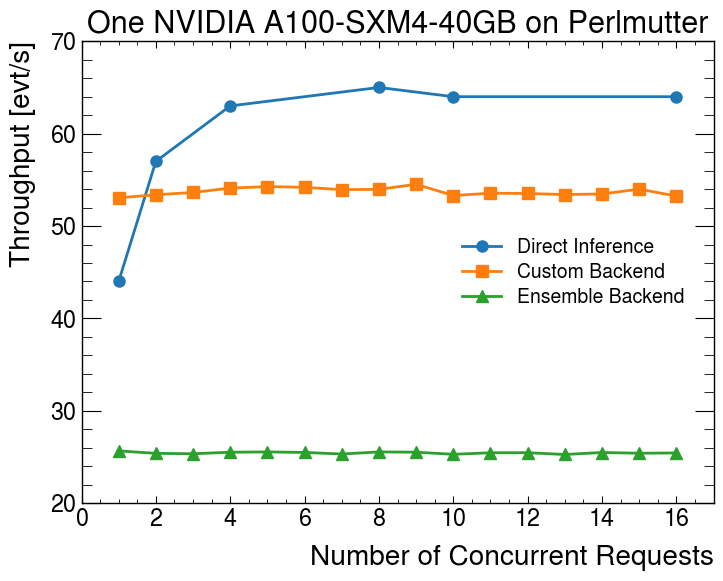

In [4]:
fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(direct_inference_results["Concurrency"], direct_inference_results[var_name], label="Direct Inference", marker="o")
ax.plot(custom_backend_results["Concurrency"], custom_backend_results[var_name], label="Custom Backend", marker="s")
ax.plot(ensemble_backend_results["Concurrency"], ensemble_backend_results[var_name], label="Ensemble Backend", marker="^")

ax.set_xlim(0, 17)
ax.set_xlabel("Number of Concurrent Requests")
ax.set_ylabel("Throughput [evt/s]")
ax.set_title("One NVIDIA A100-SXM4-40GB on Perlmutter", fontsize=22)

ax.legend()
fig.savefig("throughput_vs_concurrency_1inst_1gpu.pdf", dpi=600, bbox_inches="tight")
fig.savefig("throughput_vs_concurrency_1inst_1gpu.png", dpi=600, bbox_inches="tight")


# Max Throughput vs Instances 

In [5]:
custom_backend_results_path = "/pscratch/sd/h/hrzhao/Projects/exatrkx-service/evaluate/slurm/good-1gpu-slurm-16730083/"
ensemble_backend_results_path = "/pscratch/sd/h/hrzhao/Projects/exatrkx-service/evaluate_ensemble/slurm/good-1gpu-slurm-16748159/"
custom_backend_results_path = check_inputpath(custom_backend_results_path)
ensemble_backend_results_path = check_inputpath(ensemble_backend_results_path)

pattern = r'(\d+)insts'
sync_mode = "sync"
n_instance_threshold = 6

def extract_number_GPUutilization(s):
    match = re.search(r'(\d+\.\d+)', s)
    if match:
        return float(match.group(1))
    return None


In [8]:
def exatract_perf_vs_instances(backend_results_path):
    backend_results = {
        "n_instances": [],
        "Throughput_mean": [],
        "Throughput_std": [], 
        "GPU Utilization": [],
    }

    different_ins_results_path = sorted([item for item in backend_results_path.iterdir() if item.is_dir()])
    for instance_result_path in different_ins_results_path:
        
        match = re.search(pattern, instance_result_path.stem)
        if match:
            n_instance = int(match.group(1)) 
        else:
            raise ValueError("No instance number found in the path.") 

        backend_results["n_instances"].append(n_instance)
        csv_file_pattern = f"*_{sync_mode}.csv"
        csv_file = sorted(instance_result_path.glob(csv_file_pattern))[0]

        pd_csv = read_perf_analyzer_output(csv_file)

        pd_saturated = pd_csv.query(f"Concurrency >= {n_instance_threshold}")
        backend_results["Throughput_mean"].append(pd_saturated[var_name].mean())
        backend_results["Throughput_std"].append(pd_saturated[var_name].std())
        
        # gpu_util = pd_saturated['Avg GPU Utilization'].apply(extract_number_GPUutilization).mean()
        gpu_util = pd_saturated['Avg GPU Utilization'].mean()
        backend_results["GPU Utilization"].append(gpu_util)

    return backend_results

In [9]:
custom_backend_results = exatract_perf_vs_instances(custom_backend_results_path)

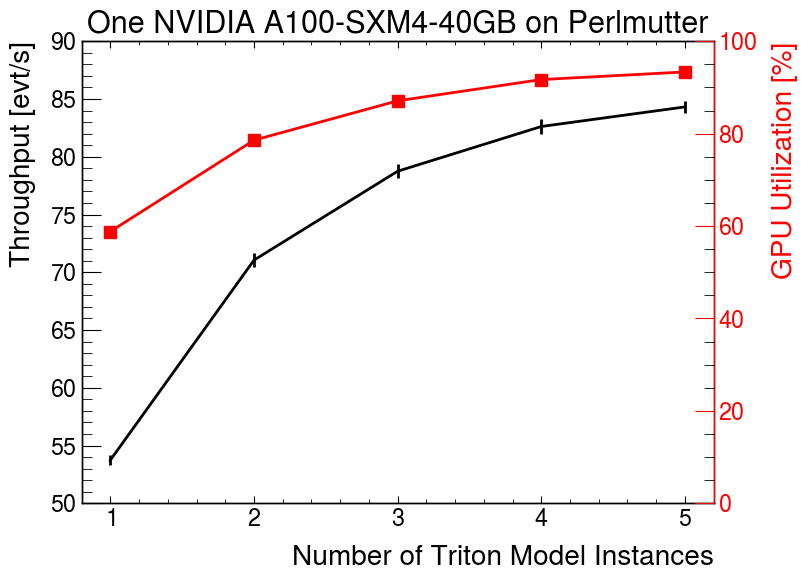

In [10]:
fig, ax = plt.subplots(figsize=(8, 6))

ax.set_xticks(custom_backend_results["n_instances"])
ax.errorbar(custom_backend_results["n_instances"], 
            custom_backend_results["Throughput_mean"], 
            yerr=custom_backend_results["Throughput_std"], 
            label="Custom Backend", color="black")

# twin object for two different y-axis on the sample plot
ax2_color = "red"
ax2=ax.twinx()
ax2.plot(custom_backend_results["n_instances"], 
         np.array(custom_backend_results["GPU Utilization"]) * 100, 
         label="GPU Utilization", color="red", marker="s")

ax2.tick_params(axis='y', colors=ax2_color)
ax2.spines['right'].set_color(ax2_color)

ax.set_xlabel("Number of Triton Model Instances")
ax.set_ylabel("Throughput [evt/s]")
ax.set_title("One NVIDIA A100-SXM4-40GB on Perlmutter", fontsize=22)

ax2.set_ylim(0,100)
ax2.set_ylabel("GPU Utilization [%]", color=ax2_color)

ax.set_xlim(0.8, 5.2)

fig.savefig("avg_throughput_vs_instances_1gpu.pdf", dpi=600, bbox_inches="tight")
fig.savefig("avg_throughput_vs_instances_1gpu.png", dpi=600, bbox_inches="tight")